In [2]:
# pip install -U pymoo

In [3]:
import numpy as np
import pandas as pd
import json

from data_preprocess import *
from run_ga import *
import matplotlib.pyplot as plt
import pickle

/Users/namjihyeon/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-04 20:09:21,937	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [17]:
tet_path = "./data/tet.json"
fdr_path = "./data/all_class_mutation/Chart-1_fdr.json"

with open(tet_path, 'r') as f:
    tet_data = json.load(f)


with open(fdr_path, 'r') as f:
    fdr_data = json.load(f)

chart_1_tet = tet_data['Chart-1']
chart_1_fdr = dict()

for key, value in fdr_data['Chart_1'].items():
    chart_1_fdr[key] = value['mutation-score']


chart_1_tet = sorted(chart_1_tet.items())
chart_1_fdr = sorted(chart_1_fdr.items())

In [5]:
tests = [i[0] for i in chart_1_tet]
execution_times = np.array([i[1] for i in chart_1_tet])
fault_detections = np.array([i[1] for i in chart_1_fdr])

test_cases = np.column_stack((execution_times, fault_detections))
adequacy_scores = get_adequacy_scores(fault_detections)

Scaling Method: min_max


In [6]:
bitflip = run_nsga(test_cases, False)


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False


Using 1/N Mutation 
Mean execution Time 5.4820612244897955
Mean Fault Detection Rate 2.154656080459205


In [7]:
adeq = run_nsga_with_adequecy(test_cases, adequacy_scores, False)


 Using Adequacy Score
Mean execution Time 5.615545454545455
Mean Fault Detection Rate 2.1894730200393724


In [10]:
datadir = 'data/experiment_result'
for pkl_file in os.listdir(datadir):
        if pkl_file.endswith('adeq.pkl'):
            with open(os.path.join(datadir, pkl_file), 'rb') as f: # load pickle file for projects from merged_data
                adeq_res  = pickle.load(f)
        elif pkl_file.endswith('flip.pkl'):
            with open(os.path.join(datadir, pkl_file), 'rb') as f: # load pickle file for projects from merged_data
               bitflip_res = pickle.load(f)
            plt.scatter(bitflip_res[:, 0], bitflip_res[:, 1], label="Bitflip")
            plt.scatter(adeq_res[:, 0], adeq_res[:, 1], label="Adequacy")
            plt.xlabel("TET")
            plt.ylabel("FDR")
            plt.legend()

In [18]:
# bitflip_res = np.abs(bitflip.F)
# adeq_res = np.abs(adeq.F)

# plt.scatter(bitflip_res[:, 0], bitflip_res[:, 1], label="Bitflip")
# plt.scatter(adeq_res[:, 0], adeq_res[:, 1], label="Adequacy")
# plt.xlabel("TET")
# plt.ylabel("FDR")
# plt.legend()

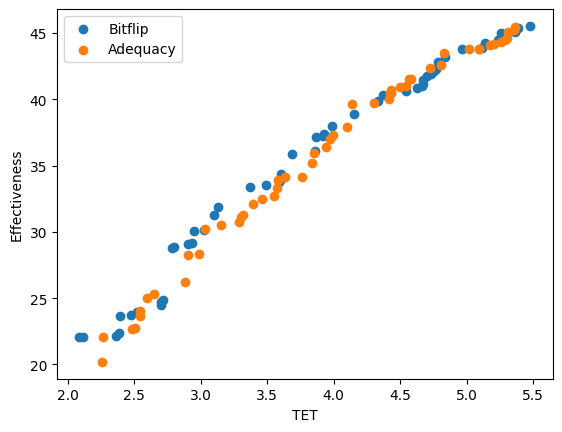

In [19]:
with open('data/experiment_result/f_cov_m_all/Chart_1_bitflip.pkl', 'rb') as f:
    bitflip = pickle.load(f)

with open('data/experiment_result/f_cov_m_cov/Chart_1_adeq.pkl', 'rb') as f:
    adeq = pickle.load(f)
# print(data.F)

bitflip_res = bitflip_res = np.abs(bitflip.F)
adeq_res = np.abs(adeq.F)

plt.scatter(bitflip_res[:, 0], bitflip_res[:, 1], label="Bitflip")
plt.scatter(adeq_res[:, 0], adeq_res[:, 1], label="Adequacy")
plt.xlabel("TET")
plt.ylabel("Effectiveness")
plt.legend()

In [20]:
types = ["f_cov_m_fdr", "f_fdr_m_fdr"]
tet_dict = {}
for type in types:
    for target in os.listdir('./data/merged_data'):
        pid, vid = os.path.splitext(target)[0].split('_')

        with open(f'data/experiment_result/{type}/{pid}_{vid}_bitflip.pkl', 'rb') as f:
            bitflip = pickle.load(f)

        with open(f'data/experiment_result/{type}/{pid}_{vid}_adeq.pkl', 'rb') as f:
            adeq = pickle.load(f)

        with open(f'data/merged_data/{pid}_{vid}.pkl', 'rb') as f:
            data = pickle.load(f)

        with open(f"data/failing_tests/{pid}-{vid}/failing_tests", "r") as f:
            failing_tests = f.readlines()

        min_id_adeq = None
        for i, sol in enumerate(adeq.X):
            # print(data.index[sol].shape)
            selected_tests = data.index[sol]
            if all(test in selected_tests for test in failing_tests):
                tet = adeq.F[i, 0]
                if min_id_adeq == None:
                    min_id_adeq = i
                elif tet < adeq.F[min_id_adeq, 0]:
                    min_id_adeq = i

        min_id_bitflip = None
        for i, sol in enumerate(bitflip.X):
            # print(data.index[sol].shape)
            selected_tests = data.index[sol]
            if all(test in selected_tests for test in failing_tests):
                tet = bitflip.F[i, 0]
                if min_id_bitflip == None:
                    min_id_bitflip = i
                elif tet < bitflip.F[min_id_bitflip, 0]:
                    min_id_bitflip = i

        # print("Adeq tet")
        # print(adeq.F[min_id_adeq, 0])
        # print("Bitflip tet")
        # print(bitflip.F[min_id_bitflip, 0])
        # print("\n")
        tet_dict[f"{pid}_{vid}"] = {"adeq": adeq.F[min_id_adeq, 0], "bigflip": bitflip.F[min_id_bitflip, 0]}
    # with
    print(type)
    print(tet_dict)
    with open(f"./data/experiment_result/{type}/min_tet_with_failing_tests.json", 'w') as f:
        json.dump(tet_dict, f)


f_cov_m_fdr
{'JacksonCore_26': {'adeq': 2.367, 'bigflip': 2.0460000000000003}, 'Chart_1': {'adeq': 2.4610000000000003, 'bigflip': 2.26}, 'Lang_1': {'adeq': 0.098, 'bigflip': 0.081}, 'Csv_16': {'adeq': 0.05700000000000001, 'bigflip': 0.276}, 'Time_1': {'adeq': 1.473, 'bigflip': 1.602}, 'Cli_40': {'adeq': 0.0, 'bigflip': 0.0}, 'JxPath_22': {'adeq': 1.9080000000000004, 'bigflip': 1.6800000000000002}}
f_fdr_m_fdr
{'JacksonCore_26': {'adeq': 1.3679999999999999, 'bigflip': 1.5790000000000002}, 'Chart_1': {'adeq': 2.152, 'bigflip': 2.203}, 'Lang_1': {'adeq': 0.12000000000000001, 'bigflip': 0.083}, 'Csv_16': {'adeq': 0.08600000000000002, 'bigflip': 0.195}, 'Time_1': {'adeq': 1.4329999999999998, 'bigflip': 1.678}, 'Cli_40': {'adeq': 0.001, 'bigflip': 0.001}, 'JxPath_22': {'adeq': 1.1090000000000002, 'bigflip': 0.9120000000000001}}
